$$
\Huge \textbf{Part fine-tuning}
$$


---



# 1) setup

---



In [1]:
import os
import sys
import glob
from tqdm import tqdm
import random
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import torchvision.transforms as transforms
from collections import defaultdict
import pickle
from datetime import datetime
import pandas as pd
!rm -rf semantic-correspondence

!git clone https://github.com/MarcotteS/semantic-correspondence.git
import sys
sys.path.append('/content/semantic-correspondence/src')

from fine_tunning.CorrespondenceMatcher2 import CorrespondenceMatcher2
from fine_tunning.ptFilesLoader import load_matcher_from_drive_ckpt
from evaluation import CorrespondenceEvaluator,evaluate_model
from analyzer import ResultsAnalyzer
from correspondence import CorrespondenceMatcher
from models import DINOv2Extractor,DINOv3Extractor,SAMExtractor
from dataset import SPairDataset,denorm,draw_image_with_keypoints,visualize_sample,collate_fn_correspondence

Cloning into 'semantic-correspondence'...
remote: Enumerating objects: 436, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 436 (delta 133), reused 150 (delta 70), pack-reused 215 (from 1)
Receiving objects: 100% (436/436), 3.68 MiB | 9.70 MiB/s, done.
Resolving deltas: 100% (256/256), done.


#                                 Data

---




In [2]:
!wget https://cvlab.postech.ac.kr/research/SPair-71k/data/SPair-71k.tar.gz

--2026-01-29 15:16:17--  https://cvlab.postech.ac.kr/research/SPair-71k/data/SPair-71k.tar.gz
Resolving cvlab.postech.ac.kr (cvlab.postech.ac.kr)... 141.223.85.126
Connecting to cvlab.postech.ac.kr (cvlab.postech.ac.kr)|141.223.85.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 226961117 (216M) [application/x-gzip]
Saving to: ‘SPair-71k.tar.gz’

SPair-71k.tar.gz    100%[===================>] 216.45M  35.1MB/s    in 6.7s    

2026-01-29 15:16:25 (32.1 MB/s) - ‘SPair-71k.tar.gz’ saved [226961117/226961117]



In [3]:
!tar -xf SPair-71k.tar.gz

In [4]:
image_size = 518 # Images must be multiples of 14 for DINOv2 or 16 for DINOv3.
dataset = SPairDataset(
        datapath='.',
        split='trn', #change to trn !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        img_size=image_size,
        category='all'
    )

train_loader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn_correspondence
)

Loading SPair-71k trn annotations...


100%|██████████| 53340/53340 [00:08<00:00, 6351.48it/s]


# Model

---



In [5]:
model="dinov2"
if model=="dinov2":
  extractor = DINOv2Extractor(model_name="dinov2_vitb14")
elif model=="dinov3":
  !git clone https://github.com/facebookresearch/dinov3.git
  !pip install torchmetrics
  """
  HTTP Error 403: Forbidden means that the link for dinoV3 is not available anymore
  a new link can be get by agreeding the licence at: https://ai.meta.com/resources/models-and-libraries/dinov3-downloads/
  """
  checkpoint_path = "https://dinov3.llamameta.net/dinov3_vitb16/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiNHl0amRkcWl3MGtkenJieGVtb2g0ZHEwIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3Njk4NjAyNjl9fX1dfQ__&Signature=QmqFk8Q%7ED5qCVvGC7eN1%7EroKaNmURphM4e5yzI%7E3OBdRB4TD71ca7ZsiZ4y1EuBqSKvZVf69kLPMUpJyRY8lI9t51t0giT2vrkj8nOAiB%7EgQe9OnfBshsP-Cjv-ItdOXLE%7EYhuIA2z9dFuHK3n7q%7E3nxmseRLMgzOBTMrd%7E9XBpJm-kECM1bDBU%7Eif-i12wzgofWzhp-KWbn7LOQRttskFpnAqFvtHXqS5z9qyntj0DWrx1cu8bvFxLNsKO%7E6Do8lXzNSqOfBAb-6LrnVHjBMa8kMieBGIYlqpgRzYMyJFip2OK5KKQ8CaQ8sY2rSfbkeoh4v7RhhLRuZ852yYn32w__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=1201704068775191"
  extractor = DINOv3Extractor(repo_dir='dinov3', weights=checkpoint_path)
elif model=="sam":
  !pip install git+https://github.com/facebookresearch/segment-anything.git
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
  checkpoint_path = "sam_vit_b_01ec64.pth"
  extractor = SAMExtractor(model_type="vit_b", checkpoint_path=checkpoint_path)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth


100%|██████████| 330M/330M [00:02<00:00, 163MB/s]


In [13]:
ckpt_path = "/content/DINOv3with1epochsImages518with1Layers.pt"


matcher = load_matcher_from_drive_ckpt(
    ckpt_path,
    feature_extractor=extractor,
)


In [ ]:
ckpt_drive = "/content/last.pt"

export_drive_ckpt_to_local_pt(
    ckpt_path=ckpt_drive,
    feature_extractor=extractor,
    out_path="stage2_portable.pt",
)


[OK] checkpoint exporté en local → stage2_portable.pt


# 2) Training

---



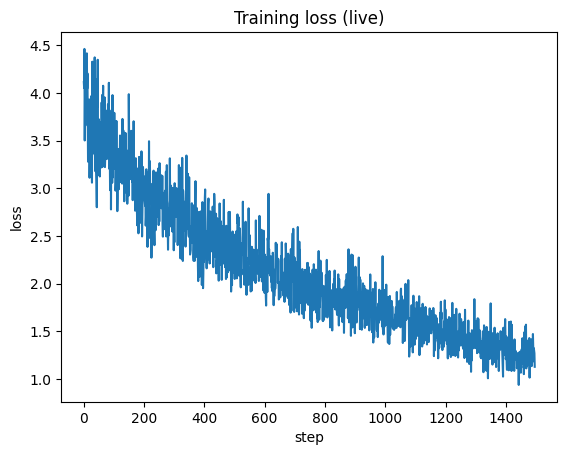

Stage2 epoch 1/1:  45%|████▍     | 1500/3334 [04:05<04:59,  6.12it/s, loss=2.12]


Epoch 1: avg loss = 2.122068
[ckpt] sauvegardé: /content/DinOV2with1500batchImages518with1Layers/last.pt


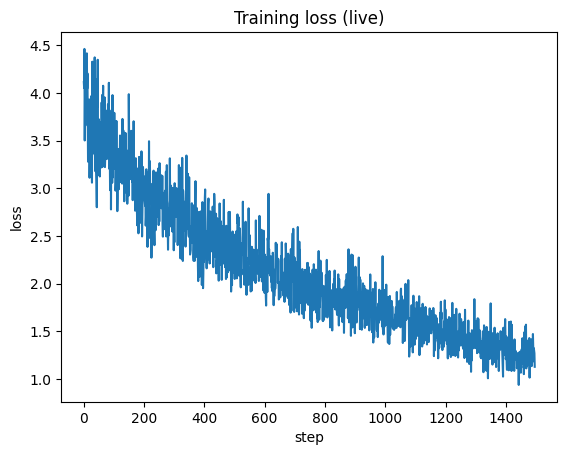

In [ ]:
matcher = CorrespondenceMatcher2(extractor)
matcher.ckpt_dir = "/content"
matcher.exp_name = "DinOV2with0.5epochsImages518with1Layers"  
matcher.resume = True                   
matcher.save_every_epoch = 1            
from fine_tunning.train import train_stage2
matcher = train_stage2(
    matcher=matcher,
    train_loader=train_loader,
    n_epochs=1,            
    n_last_blocks=1,       
    lr=2e-5,
    weight_decay=0.01,
    tau=0.07,
    max_batches_per_epoch=1500,  # always a big number or exceptionaly less to do half an epoch like here
    use_amp=True,isSam=False
)

# 3) Evaluation (metrics generation)

---



Loading SPair-71k test annotations...


Evaluating: 100%|██████████| 765/765 [07:39<00:00,  1.66it/s]



EVALUATION SUMMARY

📊 Overall PCK:
----------------------------------------------------------------------
  PCK@0.05: 59.41%
  PCK@0.10: 74.32%
  PCK@0.15: 80.52%
  PCK@0.20: 84.39%

📁 Per-Category PCK:
----------------------------------------------------------------------
  aeroplane       → 0.05: 70.99% | 0.10: 81.62% | 0.15: 86.35% | 0.20: 89.68%
  bicycle         → 0.05: 51.97% | 0.10: 66.66% | 0.15: 72.40% | 0.20: 77.11%
  bird            → 0.05: 79.00% | 0.10: 90.94% | 0.15: 94.57% | 0.20: 96.83%
  boat            → 0.05: 37.33% | 0.10: 55.02% | 0.15: 63.82% | 0.20: 69.31%
  bottle          → 0.05: 41.44% | 0.10: 57.93% | 0.15: 64.75% | 0.20: 69.20%
  bus             → 0.05: 69.38% | 0.10: 84.44% | 0.15: 88.50% | 0.20: 90.46%
  car             → 0.05: 63.98% | 0.10: 76.81% | 0.15: 80.65% | 0.20: 83.66%
  cat             → 0.05: 83.70% | 0.10: 88.90% | 0.15: 91.38% | 0.20: 94.08%
  chair           → 0.05: 50.47% | 0.10: 59.34% | 0.15: 64.90% | 0.20: 69.25%
  cow             → 0.0

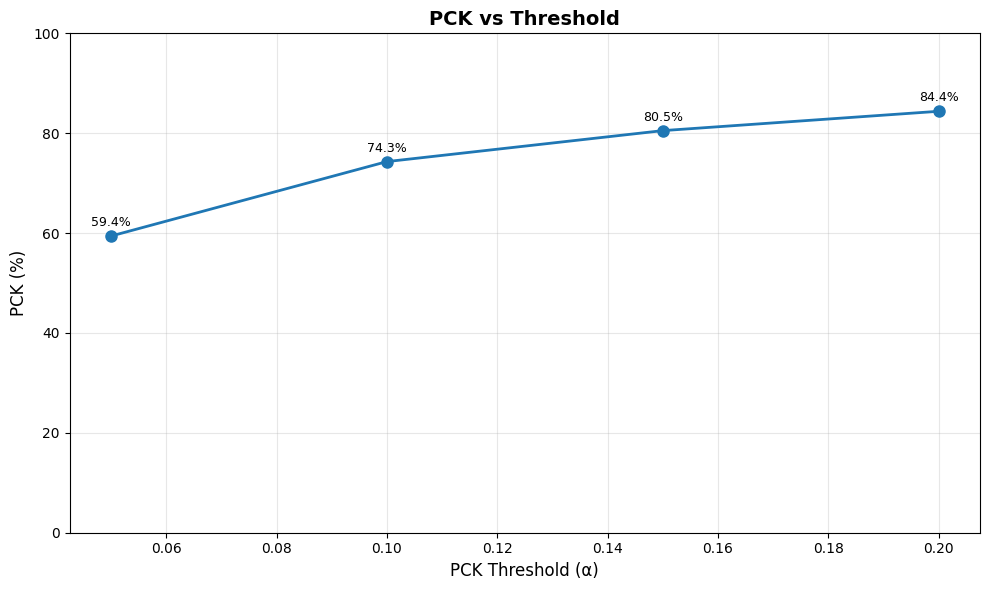

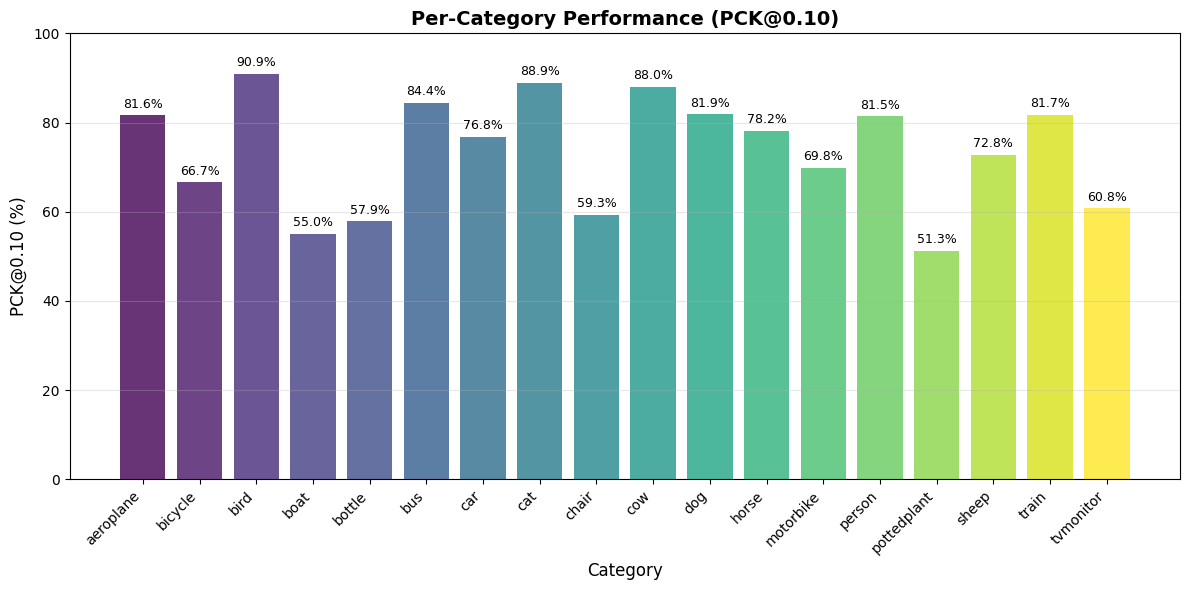

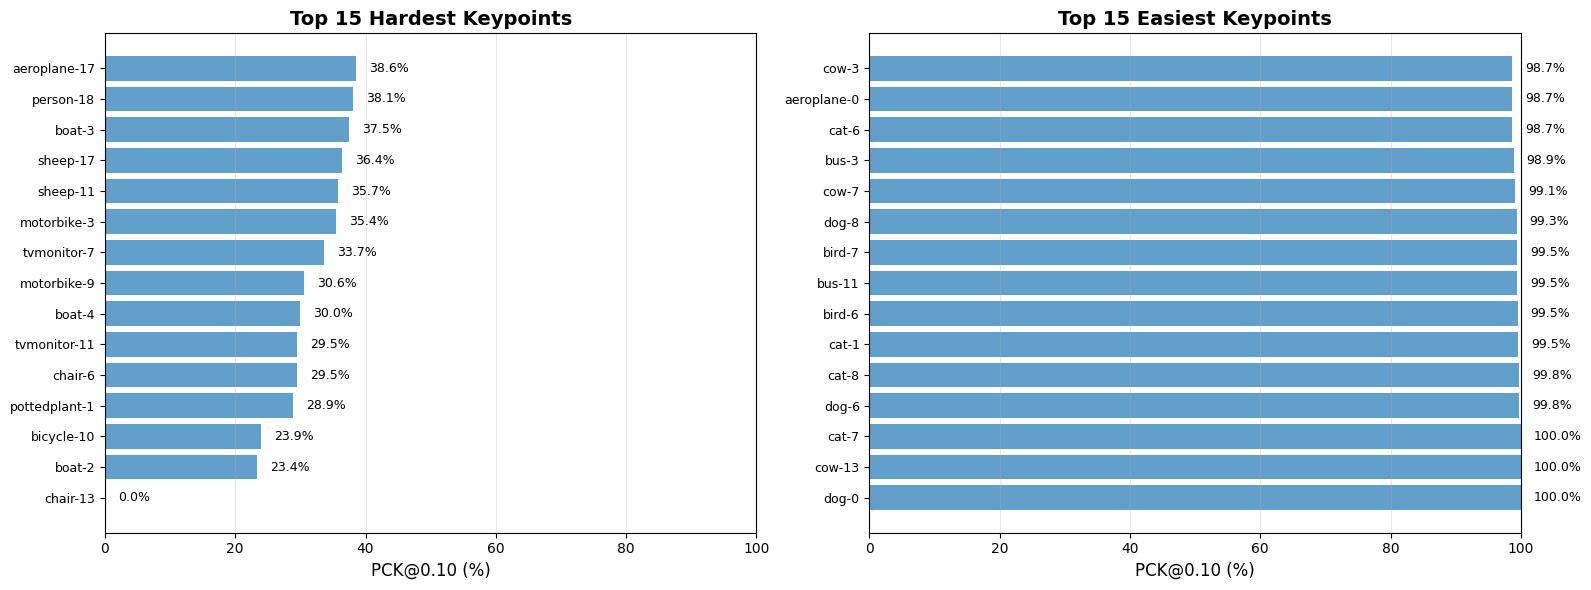

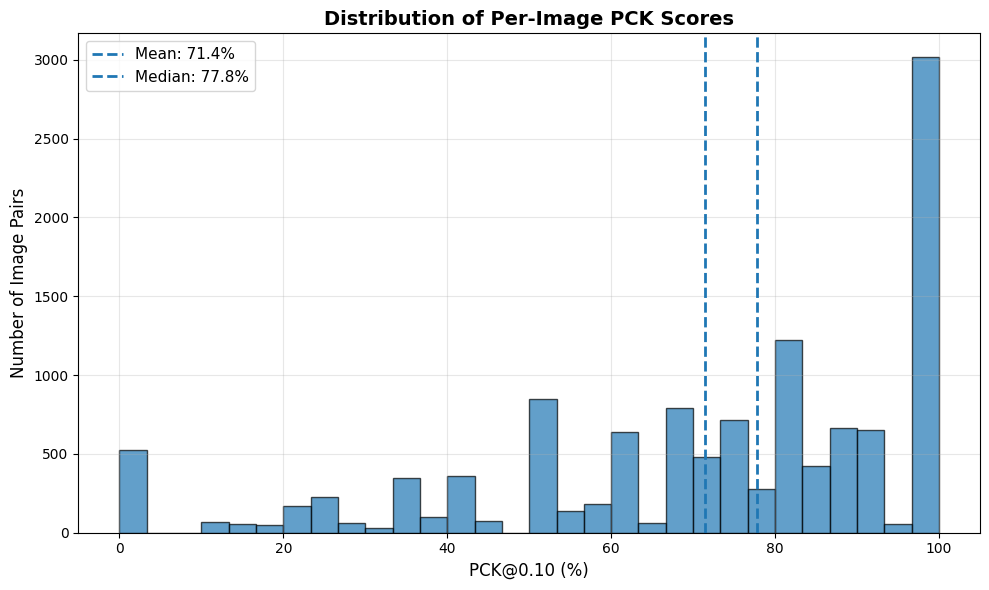

✅ Exported all metrics to ./results/dinov2_vitb14_finetunened/
✅ Report generated in ./results/dinov2_vitb14_finetunened/
   Overall PCK  aeroplane    bicycle       bird       boat    bottle  \
0    74.316185  81.624864  66.658044  90.938362  55.020673  57.92588   

         bus        car        cat      chair       cow        dog      horse  \
0  84.435016  76.809577  88.899645  59.337349  87.98059  81.861724  78.210034   

   motorbike     person  pottedplant      sheep      train  tvmonitor  
0  69.811875  81.471136    51.262179  72.763158  81.709007  60.781378  


In [ ]:
# On réutilise le même extractor (poids fine-tunés)
import os
os.chdir("/content")
image_size = 518
matcher_eval = CorrespondenceMatcher(extractor)
dataset = SPairDataset(
        datapath='.',
        split='test',
        img_size=image_size,
        category='all'
    )

dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn_correspondence
)
metrics_after = evaluate_model(matcher_eval, dataloader,run_name="DINOv3with1epochsImages518with1LayersMetrics")
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = "dinov2_vitb14"

results_dict = {
    'metrics': metrics_after,
    'model': model_name,
    'timestamp': timestamp
}

with open(f'results_{model_name}_{image_size}_{timestamp}.json', 'w') as f:
    json.dump(results_dict, f, indent=2)

print(f"Results saved!")
analyzer = ResultsAnalyzer(metrics_after)

analyzer.generate_report(save_dir='./results/dinov2_vitb14_finetunened')
summary_df = analyzer.create_summary_table(threshold=0.10)
print(summary_df)